In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Import the dataset generator
from sample_dataset import generate_credit_risk_dataset, prepare_data_for_models



In [2]:
def create_monolithic_model(input_dim=20):
    """
    Create a monolithic neural network model
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model



In [3]:
def create_meta_learning_model():
    """
    Create a meta-learning model with specialized base models
    """
    # Base model 1: Financial features (first 10 features)
    financial_input = Input(shape=(10,), name='financial_input')
    x1 = Dense(64, activation='relu')(financial_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(32, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    financial_output = Dense(16, activation='relu', name='financial_features')(x1)
    
    # Base model 2: Behavioral features (last 10 features)
    behavioral_input = Input(shape=(10,), name='behavioral_input')
    x2 = Dense(64, activation='relu')(behavioral_input)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(32, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    behavioral_output = Dense(16, activation='relu', name='behavioral_features')(x2)
    
    # Meta-model: Combines outputs from both base models
    combined = Concatenate(name='feature_fusion')([financial_output, behavioral_output])
    z = Dense(32, activation='relu')(combined)
    z = Dropout(0.3)(z)
    z = Dense(16, activation='relu')(z)
    z = Dropout(0.2)(z)
    final_output = Dense(1, activation='sigmoid', name='risk_prediction')(z)
#    final_output = Dense(1, activation='sigmoid', name='risk_prediction')(combined)
    
    meta_model = Model(
        inputs=[financial_input, behavioral_input],
        outputs=final_output,
        name='meta_learning_model'
    )
    
    meta_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return meta_model



In [4]:
def train_and_evaluate_models():
    """
    Train and evaluate both models on the credit risk dataset
    """
    print("=" * 60)
    print("MONOLITHIC vs META-LEARNING MODEL COMPARISON")
    print("=" * 60)
    
    # Generate dataset
    print("\n1. Generating credit risk dataset...")
    X, y, feature_names, df = generate_credit_risk_dataset(n_samples=8000)
    data = prepare_data_for_models(X, y, test_size=0.2)
    
    print(f"   Dataset size: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"   Default rate: {np.mean(y):.1%}")
    print(f"   Train/Test split: {len(data['monolithic']['y_train'])}/{len(data['monolithic']['y_test'])}")
    
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    print("\n2. Training Monolithic Model...")
    print("-" * 40)
    
    # Train monolithic model
    monolithic_model = create_monolithic_model()
    mono_history = monolithic_model.fit(
        data['monolithic']['X_train'],
        data['monolithic']['y_train'],
        epochs=100,
        batch_size=64,
        validation_split=0.2,
#        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate monolithic model
    mono_train_results = monolithic_model.evaluate(
        data['monolithic']['X_train'], 
        data['monolithic']['y_train'], 
        verbose=0
    )
    mono_test_results = monolithic_model.evaluate(
        data['monolithic']['X_test'], 
        data['monolithic']['y_test'], 
        verbose=0
    )
    
    print("\n3. Training Meta-Learning Model...")
    print("-" * 40)
    
    # Train meta-learning model
    meta_model = create_meta_learning_model()
    meta_history = meta_model.fit(
        data['meta_learning']['X_train'],
        data['meta_learning']['y_train'],
        epochs=300,
        batch_size=64,
        validation_split=0.2,
#        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate meta-learning model
    meta_train_results = meta_model.evaluate(
        data['meta_learning']['X_train'], 
        data['meta_learning']['y_train'], 
        verbose=0
    )
    meta_test_results = meta_model.evaluate(
        data['meta_learning']['X_test'], 
        data['meta_learning']['y_test'], 
        verbose=0
    )
    
    print("\n4. RESULTS COMPARISON")
    print("=" * 60)
    
    # Print results
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall']
    
    print(f"{'Model':<20} {'Dataset':<10} {'Loss':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<8}")
    print("-" * 70)
    print(f"{'Monolithic':<20} {'Train':<10} {mono_train_results[0]:<8.4f} {mono_train_results[1]:<10.4f} {mono_train_results[2]:<10.4f} {mono_train_results[3]:<8.4f}")
    print(f"{'Monolithic':<20} {'Test':<10} {mono_test_results[0]:<8.4f} {mono_test_results[1]:<10.4f} {mono_test_results[2]:<10.4f} {mono_test_results[3]:<8.4f}")
    print(f"{'Meta-Learning':<20} {'Train':<10} {meta_train_results[0]:<8.4f} {meta_train_results[1]:<10.4f} {meta_train_results[2]:<10.4f} {meta_train_results[3]:<8.4f}")
    print(f"{'Meta-Learning':<20} {'Test':<10} {meta_test_results[0]:<8.4f} {meta_test_results[1]:<10.4f} {meta_test_results[2]:<10.4f} {meta_test_results[3]:<8.4f}")
    
    # Calculate improvement
    accuracy_improvement = (meta_test_results[1] - mono_test_results[1]) * 100
    precision_improvement = (meta_test_results[2] - mono_test_results[2]) * 100
    
    print(f"\n5. META-LEARNING IMPROVEMENTS:")
    print(f"   Test Accuracy: {accuracy_improvement:+.2f} percentage points")
    print(f"   Test Precision: {precision_improvement:+.2f} percentage points")
    
    # Generate predictions for detailed analysis
    mono_pred = monolithic_model.predict(data['monolithic']['X_test'], verbose=0)
    meta_pred = meta_model.predict(data['meta_learning']['X_test'], verbose=0)
    
    mono_pred_binary = (mono_pred > 0.5).astype(int)
    meta_pred_binary = (meta_pred > 0.5).astype(int)
    
    print(f"\n6. DETAILED CLASSIFICATION REPORTS:")
    print("\nMonolithic Model:")
    print(classification_report(data['monolithic']['y_test'], mono_pred_binary))
    
    print("\nMeta-Learning Model:")
    print(classification_report(data['meta_learning']['y_test'], meta_pred_binary))
    
    # Plot training histories
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(mono_history.history['accuracy'], label='Monolithic Train')
    plt.plot(mono_history.history['val_accuracy'], label='Monolithic Val')
    plt.plot(meta_history.history['accuracy'], label='Meta-Learning Train')
    plt.plot(meta_history.history['val_accuracy'], label='Meta-Learning Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(mono_history.history['loss'], label='Monolithic Train')
    plt.plot(mono_history.history['val_loss'], label='Monolithic Val')
    plt.plot(meta_history.history['loss'], label='Meta-Learning Train')
    plt.plot(meta_history.history['val_loss'], label='Meta-Learning Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.hist(mono_pred, alpha=0.7, label='Monolithic', bins=20)
    plt.hist(meta_pred, alpha=0.7, label='Meta-Learning', bins=20)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'monolithic_model': monolithic_model,
        'meta_model': meta_model,
        'data': data,
        'results': {
            'monolithic': {'train': mono_train_results, 'test': mono_test_results},
            'meta_learning': {'train': meta_train_results, 'test': meta_test_results}
        }
    }



MONOLITHIC vs META-LEARNING MODEL COMPARISON

1. Generating credit risk dataset...
   Dataset size: 8000 samples, 20 features
   Default rate: 48.6%
   Train/Test split: 6400/1600

2. Training Monolithic Model...
----------------------------------------
Epoch 1/100


/Users/peekay/projects/AI/meta_learning/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6457 - loss: 0.6220 - precision: 0.6467 - recall: 0.6022 - val_accuracy: 0.7750 - val_loss: 0.4847 - val_precision: 0.7611 - val_recall: 0.7783
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.7500 - loss: 0.5098 - precision: 0.7529 - recall: 0.7252 - val_accuracy: 0.7812 - val_loss: 0.4653 - val_precision: 0.7770 - val_recall: 0.7670
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.7607 - loss: 0.4909 - precision: 0.7642 - recall: 0.7364 - val_accuracy: 0.7836 - val_loss: 0.4643 - val_precision: 0.8061 - val_recall: 0.7265
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7701 - loss: 0.4798 - precision: 0.7740 - recall: 0.7464 - val_accuracy: 0.7797 - val_loss: 0.4624 - val_precision: 0.7867 - val_recall: 0.7460
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7773 - loss: 0.4720 - precision: 0.7895 - recall: 0.7408 - val_accuracy: 0.7781 - val_loss: 0.4638 - va

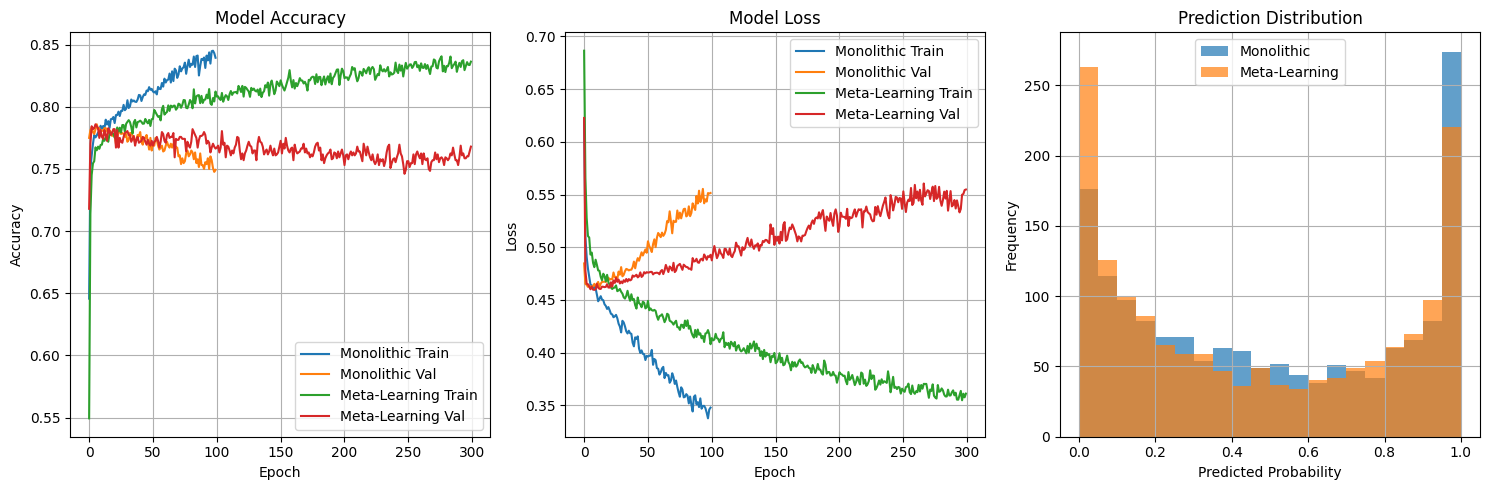

In [5]:
if __name__ == "__main__":
    results = train_and_evaluate_models()